## Detailed Age investigation

In [1]:
# %load_ext autoreload
# %autoreload 2

import cf_xarray
import intake
import xarray as xr
import numpy as np

from cmip6_preprocessing.utils import cmip6_dataset_id
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import (
    match_metrics,
    interpolate_grid_label,
    merge_variables,
    concat_experiments,
)

from cmip6_preprocessing.drift_removal import match_and_remove_trend
from fastprogress.fastprogress import progress_bar
from cmip6_omz.utils import cmip6_collection, o2_models
from cmip6_omz.upstream_stash import (
    pick_first_member,
    construct_static_dz,
    concat_time,
    zarr_exists,
)
from cmip6_omz.units import convert_mol_m3_mymol_kg

from xarrayutils.file_handling import maybe_create_folder

### needs cleaning
from cmip6_omz.omz_tools import omz_thickness_efficient, mask_basin
import matplotlib.pyplot as plt
from cmip6_omz.upstream_stash import append_write_zarr

In [3]:
# import hvplot.xarray
# import panel.widgets as pnw

In [28]:
cluster.close()
client.close()

In [29]:
# set up dask
from dask.distributed import LocalCluster, Client
mem_total = 128
workers = 4
threads = 8 # 4*6 seemed to work quite well, but I would like this to perform a bit better
cluster = LocalCluster(
    memory_limit=f"{int(mem_total/workers)}GiB",
    dashboard_address=9999,
    threads_per_worker=threads,
    n_workers = workers,
                      )
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:38779' processes=4 threads=32, memory=128.00 GiB>

In [5]:
# Global Parameters

hist_slice = slice('1950', '2000')
scen_slice = slice('2050', '2075')

In [ ]:
col = cmip6_collection(zarr=False)
kwargs = dict(
    aggregate=False,
    zarr_kwargs={"decode_times": True, "use_cftime": True, "consolidated": True},
    cdf_kwargs={"decode_times": True, "use_cftime": True, "chunks": {"time": 3}},
    preprocess=combined_preprocessing,
)

variable_ids = ["thetao", "so", "o2", "agessc"]  # "mlotst"
metric_variable_ids = ["thkcello", "areacello"]  # "mlotst"

# models = o2_models()
models = [
    "CanESM5-CanOE",
    "CanESM5",
    #          'CNRM-ESM2-1',
    "ACCESS-ESM1-5",
    'IPSL-CM6A-LR',
    'MIROC-ES2L',
    'UKESM1-0-LL',
    #      'MPI-ESM1-2-HR',
    #      'MPI-ESM1-2-LR',
    #      'MRI-ESM2-0',
    "NorESM2-LM",
    'NorESM2-MM',
    "GFDL-CM4",
    "GFDL-ESM4",
]

cat = col.search(
    source_id=models,
    grid_label=["gr", "gn"],
    experiment_id=["historical", "ssp585"],
    table_id=["Omon"],
    variable_id=variable_ids,
#     member_id="r1i1p1f1",
)
ds_dict = cat.to_dataset_dict(**kwargs)

# make a separate metric dict to catch all possible metrics!
cat_metrics = col.search(source_id=models, variable_id=metric_variable_ids)
ds_metric_dict = cat_metrics.to_dataset_dict(**kwargs)

# combine in time (only needed for netcdf collection)
ds_dict = concat_time(ds_dict)
ds_metric_dict = concat_time(ds_metric_dict)

# Brute Force add the GFDL age
# TODO: Make this nicer with the original netcdf files (not tonight though)
col_gfdl = cmip6_collection(zarr=True)
# BUG: There is something weird going on in the reading process here
# Just drop everything that is not GFDL
df = col_gfdl.df
df = df.iloc[ ['GFDL' in i for i in df['source_id']], :]
df = df.iloc[ ['agessc' in i for i in df['variable_id']], :]
col_gfdl.df = df
cat_gfdl = col_gfdl.search(
    source_id=[
        "GFDL-CM4",
        # "GFDL-ESM4",
    ],
    variable_id=["agessc"],
    experiment_id=["historical", "ssp585"],
)

ddict_gfdl_age = cat_gfdl.to_dataset_dict(**kwargs)
ddict_gfdl_age = {k:ds for k, ds in ddict_gfdl_age.items()}
ds_dict.update(ddict_gfdl_age)

# rechunk the GFDL models in depth
def maybe_rechunk(ds):
    if ds.source_id in ["GFDL-CM4","GFDL-ESM4"]:
        ds = ds.chunk({'lev':15})
    return ds
ds_dict = {k:maybe_rechunk(ds) for k,ds in ds_dict.items()}

Dataframe size before picking latest version: 2363
Getting latest version...

Dataframe size after picking latest version: 2258

Done....


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.dcpp_init_year.version.time_range.path'


/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:233: UserWarning: CMIP.MIROC.MIROC-ES2L.historical.r13i1p1f2.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:233: UserWarning: ScenarioMIP.MIROC.MIROC-ES2L.ssp585.r5i1p1f2.Omon.gn.none.thetao: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/preprocessing.py:233: UserWarning: ScenarioMIP.MIROC.MIROC-ES2L.ssp585.r8i1p1f2.Omon.gn.none.o2: Unit correction failed with: Cannot convert variables:
    incompatible units for variable 'lev': cannot convert a non-quantity using 'm' as unit
  warnings.warn(
/home/jbusecke/code/cmip6_preprocessin

## Dict Processing

In [7]:
import pathlib
# new files (change in later and get rid of `load_trend_dict` (or refactor?) and `fix_trend_metadata`)
# Load all trend files
flist = list(pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_control_drifts/').absolute().glob('*.nc'))
flist = [f for f in flist if any([v in str(f) for v in variable_ids])]
trend_dict = {}
for f in progress_bar(flist):
    trend_dict[f.stem] = xr.open_mfdataset([f])

In [8]:
import warnings

def _expected_length(ds):
    if ds.experiment_id == "historical":
        if ds.table_id == "Omon":
            return 1980
        else:
            warnings.warn(
                f"unknown table_id [{ds.table_id}] for {cmip6_dataset_id(ds)}"
            )
            return 1

    elif "ssp" in ds.experiment_id:
        if ds.table_id == "Omon":
            return 1032
        else:
            warnings.warn(
                f"unknown table_id [{ds.table_id}] for {cmip6_dataset_id(ds)}"
            )
            return 1

    elif "Control" in ds.experiment_id:
        if ds.table_id == "Omon":
            return (
                12 * 200
            )  # just give a low number here so none of the controls are dropped
        else:
            warnings.warn(
                f"unknown table_id [{ds.table_id}] for {cmip6_dataset_id(ds)}"
            )
            return 1
    else:
        warnings.warn(
            f"unknown experiment_id [{ds.experiment_id}] for {cmip6_dataset_id(ds)}"
        )
        return 1


def filter_ddict(ddict):
    ddict_filtered = {}
    for name, ds in ddict.items():
        # drop everything but main variable
        ds = ds.drop([v for v in ds.data_vars if v != ds.variable_id])

        # filter out too short runs
        if "time" not in ds.dims:
            ddict_filtered[name] = ds
        else:
            if len(ds.time) < _expected_length(ds):
                print("---------DROPPED--------")
                print(name)
                print(_expected_length(ds))
                print(len(ds.time))
                print("---------DROPPED--------")
            else:
                ddict_filtered[name] = ds
    return ddict_filtered


# apply to data and metrics
ds_dict_filtered = filter_ddict(ds_dict)
ds_metric_dict_filtered = filter_ddict(ds_metric_dict)

In [9]:
# these ones are messed up...need a better way to deal with that in the previous step
# see https://github.com/jbusecke/cmip6_preprocessing/issues/175
incomplete_keys = ['CMIP.IPSL.IPSL-CM6A-LR.historical.r3i1p1f1.Omon.gn.none.area_o2']
trend_dict = {k:ds for k,ds in trend_dict.items() if k not in incomplete_keys}
# i think this should be taken care of in the filtering step above...TODO check at a later point

ddict_tracers_detrended = match_and_remove_trend(
    ds_dict_filtered,
    trend_dict,
)

# these cause trouble
problem_metrics = [
    'ACCESS-ESM1-5.gn.ssp585.Omon.r3i1p1f1.thkcello', # metric too short
    'ACCESS-ESM1-5.gn.ssp585.Omon.r2i1p1f1.thkcello', # metric too short
    'ACCESS-ESM1-5.gn.ssp585.Omon.r1i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
    'ACCESS-ESM1-5.gn.ssp585.Omon.r9i1p1f1.thkcello', # metric too short
    'ACCESS-ESM1-5.gn.ssp585.Omon.r6i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
    'ACCESS-ESM1-5.gn.ssp585.Omon.r4i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
    'ACCESS-ESM1-5.gn.ssp585.Omon.r8i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
    'ACCESS-ESM1-5.gn.ssp585.Omon.r10i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
    'ACCESS-ESM1-5.gn.ssp585.Omon.r5i1p1f1.thkcello', # metric too long (I guess I could fix that with a join='inner', but probably not worth it now
]
for key in problem_metrics:
    if key in ds_metric_dict_filtered.keys():
        del ds_metric_dict_filtered[key]
        
# this one causes problems because the time is not as long as the full data...apparently they stopped writing the thickness
# ddict_tracers_detrended_filtered = {
#     k: ds.squeeze()
#     for k, ds in ddict_tracers_detrended.items()
#     if not ("ACCESS-ESM1-5" in k and "r3i1p1f1" in k)
# }

ddict_matched = match_metrics(
    ddict_tracers_detrended,
    ds_metric_dict_filtered,
    ["areacello", "thkcello"],
    print_statistics=True,
)

/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for ScenarioMIP.NCC.NorESM2-LM.ssp585.r1i1p1f1.Omon.gn.none.thetao
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.NCC.NorESM2-LM.historical.r1i1p1f1.Omon.gn.none.agessc
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.NCC.NorESM2-LM.historical.r1i1p1f1.Omon.gn.none.so
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.NCC.NorESM2-LM.historical.r1i1p1f1.Omon.gn.none.thetao
  warnings.warn(nomatch_msg)
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a m

Processed 16 datasets.
Exact matches:{'areacello': 0, 'thkcello': 0}
Other matches:{'areacello': 8, 'thkcello': 16}
No match found:{'areacello': 8, 'thkcello': 0}


/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:591: UserWarning: No matching metrics found for areacello
  warnings.warn(f"No matching metrics found for {mv}")


In [10]:
print("interpolate grids\n")
ddict_matched_regrid = interpolate_grid_label(
    ddict_matched, merge_kwargs={"compat": "override"}
)  # This should be a default soon

interpolate grids



/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:138: UserWarning: CMIP.NCC.NorESM2-LM.historical.r1i1p1f1.Omon.gr.none.o2 failed to combine with :Could not find any variable with the target_grid_labelgn. Found these instead: ['gr']
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:138: UserWarning: ScenarioMIP.NCC.NorESM2-LM.ssp585.r1i1p1f1.Omon.gr.none.agessc failed to combine with :Could not find any variable with the target_grid_labelgn. Found these instead: ['gr']
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")


In [11]:
ddict_ex_combined = concat_experiments(
    ddict_matched_regrid,
    concat_kwargs={
        'combine_attrs': 'drop_conflicts',
        'compat': 'override',
        'coords': 'minimal'
    }
)

/home/jbusecke/code/cmip6_preprocessing/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


In [12]:
# only pick full runs (historical and ssp585)
ddict_ex_combined_full = {k:ds for k,ds in ddict_ex_combined.items() if len(ds.time)>3000}

In [13]:
def change(ds):
    ds_diff = ds.sel(time=scen_slice).mean('time') - ds.sel(time=hist_slice).mean('time')
    return ds_diff
# change_dict = {k:change(ds) for k,ds in ddict_ex_combined_full.items()}    

In [31]:
list(ddict_ex_combined_full.keys())

['CanESM5.gn.Omon.r1i1p1f1']

## Get some sort of timeseries that shows the increase in age...

In [14]:
# ds = ddict_ex_combined_full['GFDL-ESM4.gn.Omon.r1i1p1f1']
ds = ddict_ex_combined_full['']

ds_hist = ds.sel(time=hist_slice).mean('time')
ds_scen = ds.sel(time=scen_slice).mean('time')

o2_hist = convert_mol_m3_mymol_kg(ds_hist.o2.load())
o2_scen = convert_mol_m3_mymol_kg(ds_scen.o2.load())

/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [15]:
# simple try first, only the expanding regions (later try xor)
mask_hist = np.logical_and(o2_hist>=100, o2_hist<=140)
mask_scen = np.logical_and(o2_scen>=100, o2_scen<=140)
mask_grow = np.logical_and(mask_scen, ~mask_hist)

mask = mask_basin(mask_grow, drop=False).fillna(0).where(abs(mask_grow.lat) <= 30, 0)

In [25]:
vol = (ds.thkcello * ds.areacello).fillna(0).load()

distributed.utils - ERROR - ('fetch', 'memory')
Traceback (most recent call last):
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/utils.py", line 638, in log_errors
    yield
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/worker.py", line 2411, in gather_dep
    self.transition(ts, "memory", value=data[d])
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/worker.py", line 1692, in transition
    func = self._transitions[start, finish]
KeyError: ('fetch', 'memory')
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x2b0292dadf40>>, <Task finished name='Task-364' coro=<Worker.gather_dep() done, defined at /scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/site-packages/distributed/worker.py:2267> except

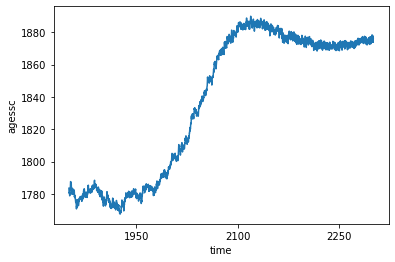

In [30]:
ds.agessc.where(mask).weighted(vol).mean(['x','y', 'lev']).plot()

In [ ]:
ds.agessc.where(mask).mean(['x','y', 'lev']).plot()

In [ ]:
mask.hvplot(groupby='lev')

  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/multiprocessing/spawn.py", line 129, in _main
    return self._bootstrap(parent_sentinel)
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/multiprocessing/process.py", line 331, in _bootstrap
    traceback.print_exc()
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib/python3.9/traceback.py", line 163, in print_exc
    exitcode = _main(fd, parent_sentinel)
    exitcode = _main(fd, parent_sentinel)
  File "/scratch/gpfs/jbusecke/conda_tigercpu/envs/cmip6_omz/lib

In [14]:
age = ds_diff.agessc.load()
o2 = convert_mol_m3_mymol_kg(ds_diff.o2.load())
o2_hist = convert_mol_m3_mymol_kg(ds.o2.sel(time=hist_slice).load())

/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [16]:
slider = pnw.IntSlider(name='lev', start=0, end=2000)
age_plot = age.interactive().interp(lev=slider)
o2_plot = o2.interactive().interp(lev=slider)
o2_hist_plot = o2_hist.interactive().interp(lev=slider)


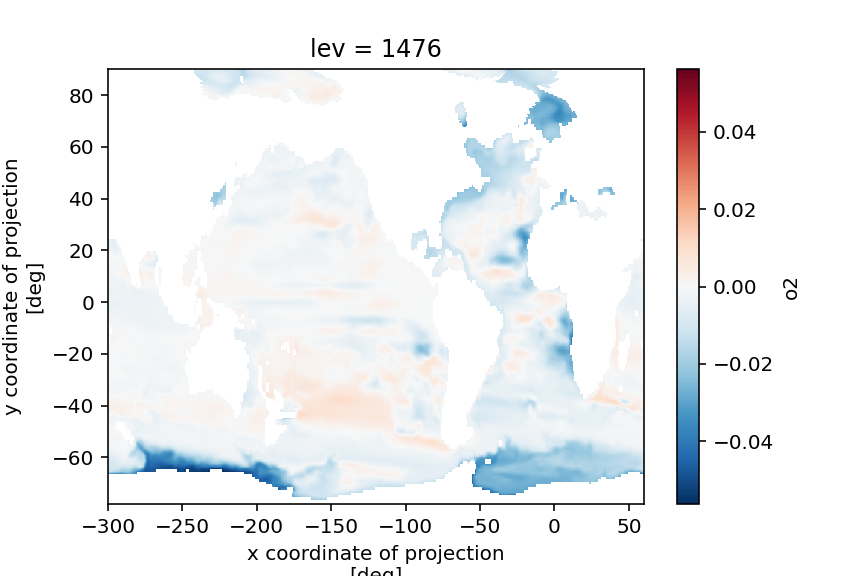

In [24]:
o2_plot.plot()

## Make an interactive plot of age

Refactor this into a cloud notebook and share with Charles

In [10]:
# ! mamba install hvplot -y

In [29]:
ds = change(ddict_ex_combined_full['GFDL-ESM4.gn.Omon.r1i1p1f1'])
age = ds.agessc.load()
o2 = ds.o2.load()

/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [50]:
o2

<xarray.DataArray 'o2' (lev: 35, y: 576, x: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y          (y) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * x          (x) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
    lat        (y, x) float32 -77.91 -77.91 -77.91 -77.91 ... 65.39 65.18 64.97
    lon        (y, x) float32 60.25 60.75 61.25 61.75 ... 59.99 59.99 59.99 60.0
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    areacello  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    thkcello   (lev, y, x) float32 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36

In [54]:
len(o2.lev)

35

This is soooo frustrating! I am apparently too stupid to understand hvplot or holoviews. It is incredibly easy to make a simple plot, but then it is just impossible to combine them into something actually useful for me...There are no docstrings that would help. GRRRRRR

In [67]:
slider = pnw.IntSlider(name='lev', start=0, end=2000)

In [68]:
age.interactive().interp(lev=slider).hvplot() + (age*10).interactive().interp(lev=slider).hvplot(kind='contour', color='k')

/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/holoviews/operation/element.py:589: UserWarning: No contour levels were found within the data range.
  contour_set = QuadContourSet(ax, *data, filled=self.p.filled,
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_new/lib/python3.9/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/busecke_etal_2021_aguadv_ne


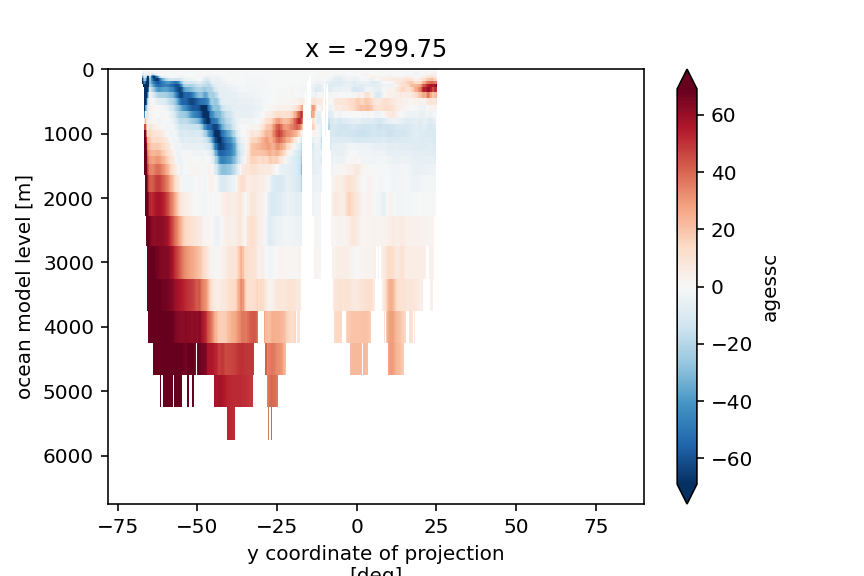

In [38]:
da.interactive(width=900).sel(x=pnw.DiscreteSlider).plot(robust=True, yincrease=False)


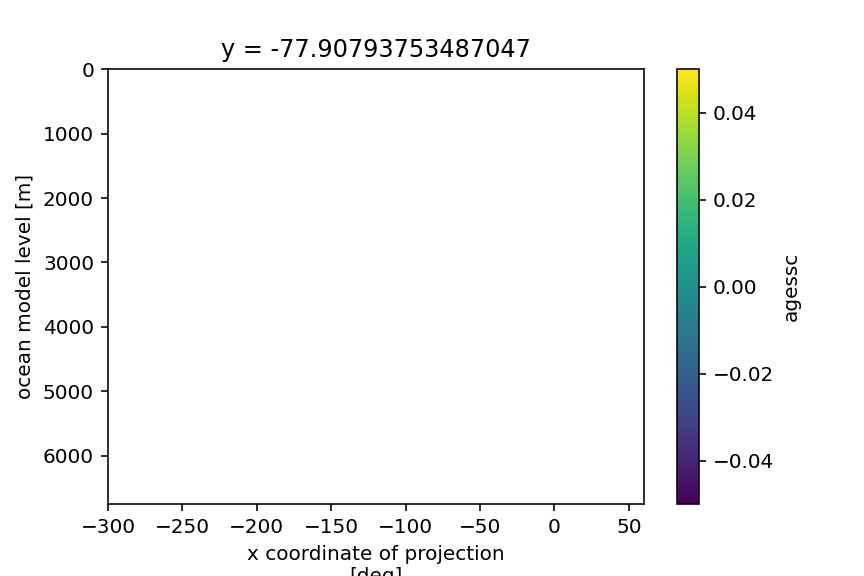

In [28]:
da.interactive().sel(y=pnw.DiscreteSlider).plot(robust=True, yincrease=False)